*********************************
      Import Data + Packages
*********************************

In [1]:
#create working directory
import os#Miscellaneous operating system interfaces
os.chdir(r'C:\\Users\\rtreichl\\Documents\\competitions\\telstra')  #working directory

#%matplotlib inline allows graphics to show below each cell (or graphics in line)
# for some reason, %matplotlib inline won't work if comments are made in the same cell

In [2]:
%matplotlib inline

In [3]:
import pandas as pd #munging and wrangling
import numpy as np  #for arrays, etc.
import matplotlib.pyplot as plt #graphs/plots
import operator
import pylab 
import scipy.stats as stats

#Model Selection -> Cross Validation
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

#Model Selection -> Metrics
from sklearn.metrics import log_loss

#xgboost
import xgboost as xgb #xgboost

#random forest
from sklearn.ensemble import RandomForestClassifier  # random forests

#bagging
from sklearn.ensemble import BaggingClassifier

#ada boost
from sklearn.ensemble import AdaBoostClassifier

#stochastic gradient descent
from sklearn.linear_model import SGDClassifier

#Support Vector Classification
from sklearn.svm import SVC

In [4]:
#use dataframes for EDA
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
resource_type=pd.read_csv('resource_type.csv')
event_type=pd.read_csv('event_type.csv')
log_feature=pd.read_csv('log_feature.csv')
severity_type=pd.read_csv('severity_type.csv')

In [5]:
############################################
#                 severity_type
############################################
#merge with training set
train_df=pd.merge(train,severity_type,on='id')

#merge with test set
test_df=pd.merge(test,severity_type,on='id')



In [6]:
#  Encoding categorical features

lbl = preprocessing.LabelEncoder()
lbl.fit(train_df['severity_type'])
train_df['severity_type'] = lbl.transform(train_df['severity_type'])
test_df['severity_type']  = lbl.transform(test_df['severity_type'])


In [7]:
######################################
#             resource_type
######################################

#group by id and create variables for each categorical value
resource_type_df=pd.pivot_table(resource_type,index=['id'], columns=['resource_type'],values=['resource_type'],
                                aggfunc=np.size,fill_value=0)
resource_type_df=resource_type_df.reset_index()

#list of columns to fix
resource_type_list=['resource_type 1', 'resource_type 10', 'resource_type 2','resource_type 3', 'resource_type 4',
                    'resource_type 5','resource_type 6', 'resource_type 7', 'resource_type 8','resource_type 9']
#convert to binary
for rtl in resource_type_list:
    resource_type_df[rtl]=np.where(resource_type_df[rtl] == 2.0,1.0,0.0)
    
#merge with training set
train_df=pd.merge(train_df,resource_type_df,on='id')
print(train_df.shape)

#merge with test set
test_df=pd.merge(test_df,resource_type_df,on='id')
print(test_df.shape)

#remove item from memory
del resource_type_df
del resource_type_list

(7381, 14)
(11171, 13)


In [8]:
####################################
#             event_type
####################################


#group by id and create variables for each categorical value
event_type_df=pd.pivot_table(event_type,index=['id'], columns=['event_type'],values=['event_type'],
                                aggfunc=np.size,fill_value=0)
event_type_df=event_type_df.reset_index()

#list of columns to fix
event_type_list=['event_type 1','event_type 10','event_type 11','event_type 12','event_type 13','event_type 14',
                 'event_type 15','event_type 17','event_type 18','event_type 19','event_type 2','event_type 20',
                 'event_type 21','event_type 22','event_type 23','event_type 24','event_type 25','event_type 26',
                 'event_type 27','event_type 28','event_type 29','event_type 3','event_type 30','event_type 31',
                 'event_type 32','event_type 33','event_type 34','event_type 35','event_type 36','event_type 37',
                 'event_type 38','event_type 39','event_type 4','event_type 40','event_type 41','event_type 42',
                 'event_type 43','event_type 44','event_type 45','event_type 46','event_type 47','event_type 48',
                 'event_type 49','event_type 5','event_type 50','event_type 51','event_type 52','event_type 53',
                 'event_type 54','event_type 6','event_type 7','event_type 8','event_type 9',]

#convert to binary
for rtl in event_type_list:
    event_type_df[rtl]=np.where(event_type_df[rtl] == 2.0,1.0,0.0)
    
#merge with training set
train_df=pd.merge(train_df,event_type_df,on='id')

#merge with test set
test_df=pd.merge(test_df,event_type_df,on='id')

#delete variables where no events as part of training set or test variables not part of training
delete_event_list=['event_type 1','event_type 17','event_type 19','event_type 33','event_type 37','event_type 4',
                   'event_type 41','event_type 52','event_type 51','event_type 48','event_type 25',]

#flag row id if event type variable to be deleted has a value greater than zero
train_df['rowid_event_flag']=0
for re in delete_event_list:
    try:
        train_df['rowid_event_flag']=np.where(train_df[re]>0,1,train_df['rowid_event_flag'])
        print(train_df[re].sum())
    except:
        pass

test_df['rowid_event_flag']=0
for re in delete_event_list:
    try:
        test_df['rowid_event_flag']=np.where(test_df[re]>0,1,test_df['rowid_event_flag'])
        print(test_df[re].sum())
    except:
        pass



for del_e in delete_event_list:
    train_df=train_df.drop(del_e,axis=1)
    test_df=test_df.drop(del_e,axis=1)

print(train_df.shape)

print(test_df.shape)


#remove from memory
del event_type_df
del event_type_list
del delete_event_list

1.0
0.0
4.0
0.0
4.0
0.0
1.0
0.0
3.0
1.0
1.0
3.0
3.0
10.0
1.0
6.0
1.0
1.0
1.0
1.0
1.0
4.0
(7381, 57)
(11171, 56)


In [9]:
#############################
#         location
#############################

#create number of location indicator variable
location_temp_train=train.groupby('location').count().reset_index()
location_temp_train=location_temp_train.drop('id',axis=1)
location_temp_train.rename(columns={'location':'location', 'fault_severity':'location_count'},inplace=True)
location_temp_train['location_count']=location_temp_train['location_count'].astype(float)
#location_temp_train['location_count']=np.log(location_temp_train['location_count']+1)

location_temp_test=test.groupby('location').count().reset_index()
location_temp_test.rename(columns={'id':'location_count'},inplace=True)
location_temp_test['location_count']=location_temp_test['location_count'].astype(float)
#location_temp_test['location_count']=np.log(location_temp_test['location_count']+1)

train_df = pd.merge(train_df,location_temp_train,on='location')
test_df  =  pd.merge(test_df,location_temp_test,on='location') 


#dummy variables for location - Train
train_df=pd.concat([train_df,pd.get_dummies(train_df['location'])], axis=1)

#drop location
train_df=train_df.drop(['location'],axis=1)

#dummy variables for location - test
test_df=pd.concat([test_df,pd.get_dummies(test_df['location'])], axis=1)

#drop location
test_df=test_df.drop(['location'],axis=1)

#remove from memory
del location_temp_train
del location_temp_test

In [10]:
#delete location dummy variables where not represented by both train and test

location_drop_list=['location 1001','location 1003','location 1004','location 1012','location 1028','location 1039',
                    'location 1040','location 1043','location 105','location 1057','location 1085','location 109',
                    'location 11','location 111','location 1114','location 1123','location 1124','location 121',
                    'location 129','location 132','location 134','location 138','location 142','location 160',
                    'location 164','location 168','location 174','location 176','location 178','location 185',
                    'location 191','location 192','location 201','location 207','location 209','location 212',
                    'location 216','location 217','location 219','location 227','location 233','location 24',
                    'location 25','location 261','location 265','location 275','location 279','location 28',
                    'location 29','location 295','location 306','location 308','location 31','location 316',
                    'location 327','location 340','location 341','location 351','location 361','location 364',
                    'location 366','location 368','location 372','location 377','location 383','location 387',
                    'location 397','location 40','location 41','location 411','location 412','location 42',
                    'location 422','location 428','location 43','location 431','location 433','location 438',
                    'location 449','location 452','location 454','location 456','location 458','location 48',
                    'location 482','location 486','location 502','location 510','location 513','location 517',
                    'location 52','location 539','location 54','location 542','location 545','location 55',
                    'location 552','location 553','location 554','location 567','location 569','location 571',
                    'location 572','location 574','location 575','location 58','location 580','location 581',
                    'location 585','location 586','location 590','location 591','location 593','location 594',
                    'location 598','location 605','location 606','location 61','location 612','location 620',
                    'location 626','location 630','location 631','location 634','location 636','location 64',
                    'location 647','location 650','location 656','location 66','location 669','location 677',
                    'location 685','location 688','location 689','location 69','location 698','location 70',
                    'location 701','location 703','location 71','location 720','location 725','location 728',
                    'location 729','location 730','location 739','location 743','location 747','location 749',
                    'location 75','location 750','location 751','location 753','location 761','location 77',
                    'location 770','location 776','location 780','location 781','location 784','location 787',
                    'location 791','location 80','location 801','location 828','location 832','location 833',
                    'location 843','location 858','location 861','location 862','location 868','location 873',
                    'location 900','location 907','location 908','location 910','location 913','location 920',
                    'location 927','location 935','location 94','location 940','location 952','location 954',
                    'location 96','location 965','location 970','location 98','location 982','location 985',
                    'location 986','location 988','location 992','location 993','location 997','location 1016',
                    'location 1027','location 1070','location 1087','location 1110','location 1126','location 113',
                    'location 180','location 188','location 196','location 214','location 225','location 241',
                    'location 247','location 250','location 254','location 259','location 267','location 277',
                    'location 285','location 287','location 291','location 293','location 304','location 319',
                    'location 329','location 331','location 333','location 339','location 346','location 355',
                    'location 357','location 362','location 37','location 389','location 391','location 399',
                    'location 407','location 423','location 424','location 487','location 5','location 511',
                    'location 512','location 516','location 523','location 524','location 529','location 531',
                    'location 537','location 548','location 551','location 555','location 556','location 559',
                    'location 56','location 560','location 562','location 57','location 573','location 578',
                    'location 588','location 597','location 614','location 617','location 621','location 624',
                    'location 633','location 635','location 65','location 67','location 694','location 715',
                    'location 716','location 717','location 718','location 748','location 766','location 785',
                    'location 813','location 847','location 866','location 888','location 928','location 953',
                    'location 958','location 969',]


#flag row id if location variable to be deleted has a value greater than zero
train_df['rowid_location_flag']=0
for re in location_drop_list:
    try:
        train_df['rowid_location_flag']=np.where(train_df[re]>0,1,train_df['rowid_location_flag'])
    except:
        pass

test_df['rowid_location_flag']=0
for re in location_drop_list:
    try:
        test_df['rowid_location_flag']=np.where(test_df[re]>0,1,test_df['rowid_location_flag'])
    except:
        pass




for ldl in location_drop_list:
    try:
        train_df=train_df.drop(ldl,axis=1)
    except:
        pass
    
for ldl in location_drop_list:
    try:
        test_df=test_df.drop(ldl,axis=1)
    except:
        pass
    
print(train_df.shape)
    
print(test_df.shape)

#remove from memory
del location_drop_list

(7381, 900)
(11171, 899)


In [11]:
#################################
#          log_feature
#################################

#transform Log_feature to natural log to put on same scale and reduce skewness
#use base 10 to make numbers as small as possible
log_feature['imp_volume']=log_feature['volume']

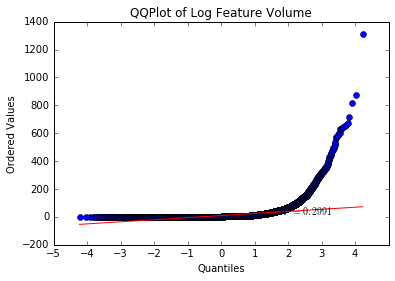

In [12]:
stats.probplot(log_feature['imp_volume'], dist="norm", plot=pylab)
plt.xticks(range(-5,5))
plt.title('QQPlot of Log Feature Volume')

In [13]:
log_feature['imp_volume']=np.where(log_feature['imp_volume']>535,535,log_feature['imp_volume'])
#log_feature['imp_volume']=np.log10(log_feature['imp_volume']+1)

In [14]:
#group by id and create variables for each categorical value
log_feature_df0=pd.pivot_table(log_feature,index=['id'], columns=['log_feature'],values=['imp_volume'],
                                aggfunc=np.sum,fill_value=0)
#save for future use
log_feature_df0.to_csv("log_feature_df0.csv")

#remove from memory
del log_feature_df0

In [15]:
#reimport log feature
log_feature_df = pd.read_csv('log_feature_df1.csv')

In [16]:
delete_feature_list=[
'feature 100',
'feature 102',
'feature 110',
'feature 112',
'feature 113',
'feature 116',
'feature 119',
'feature 12',
'feature 120',
'feature 121',
'feature 123',
'feature 124',
'feature 125',
'feature 126',
'feature 128',
'feature 129',
'feature 13',
'feature 130',
'feature 138',
'feature 139',
'feature 14',
'feature 140',
'feature 142',
'feature 143',
'feature 146',
'feature 147',
'feature 148',
'feature 151',
'feature 16',
'feature 164',
'feature 17',
'feature 173',
'feature 175',
'feature 177',
'feature 180',
'feature 184',
'feature 185',
'feature 189',
'feature 19',
'feature 192',
'feature 194',
'feature 199',
'feature 208',
'feature 21',
'feature 210',
'feature 213',
'feature 214',
'feature 216',
'feature 226',
'feature 23',
'feature 24',
'feature 241',
'feature 242',
'feature 243',
'feature 246',
'feature 247',
'feature 248',
'feature 249',
'feature 250',
'feature 251',
'feature 252',
'feature 253',
'feature 255',
'feature 256',
'feature 257',
'feature 258',
'feature 259',
'feature 260',
'feature 261',
'feature 262',
'feature 263',
'feature 264',
'feature 265',
'feature 266',
'feature 269',
'feature 270',
'feature 271',
'feature 272',
'feature 274',
'feature 275',
'feature 278',
'feature 28',
'feature 281',
'feature 282',
'feature 286',
'feature 287',
'feature 294',
'feature 295',
'feature 296',
'feature 298',
'feature 299',
'feature 3',
'feature 300',
'feature 31',
'feature 32',
'feature 320',
'feature 321',
'feature 322',
'feature 323',
'feature 324',
'feature 325',
'feature 326',
'feature 327',
'feature 329',
'feature 33',
'feature 331',
'feature 332',
'feature 333',
'feature 334',
'feature 335',
'feature 336',
'feature 337',
'feature 338',
'feature 339',
'feature 34',
'feature 340',
'feature 341',
'feature 342',
'feature 343',
'feature 344',
'feature 346',
'feature 347',
'feature 350',
'feature 351',
'feature 352',
'feature 355',
'feature 356',
'feature 358',
'feature 36',
'feature 363',
'feature 364',
'feature 367',
'feature 371',
'feature 372',
'feature 373',
'feature 379',
'feature 38',
'feature 380',
'feature 381',
'feature 382',
'feature 383',
'feature 385',
'feature 386',
'feature 4',
'feature 43',
'feature 48',
'feature 5',
'feature 57',
'feature 58',
'feature 59',
'feature 6',
'feature 67',
'feature 7',
'feature 72',
'feature 88',
'feature 89',
'feature 9',
'feature 91',
'feature 92',
'feature 93',
'feature 96',
'feature 97',
'feature 98',
'feature 90',
'feature 79',
'feature 77',
'feature 330',
'feature 328',
'feature 297',
'feature 292',
'feature 29',
'feature 288',
'feature 27',
'feature 267',
'feature 26',
'feature 254',
'feature 245',
'feature 244',
'feature 237',
'feature 215',
'feature 174',
'feature 159',
'feature 158',
'feature 144',
'feature 137',
'feature 122',
'feature 115',
'feature 114',
'feature 106',
'feature 100_flag',
'feature 102_flag',
'feature 110_flag',
'feature 112_flag',
'feature 113_flag',
'feature 116_flag',
'feature 119_flag',
'feature 12_flag',
'feature 120_flag',
'feature 121_flag',
'feature 123_flag',
'feature 124_flag',
'feature 125_flag',
'feature 126_flag',
'feature 128_flag',
'feature 129_flag',
'feature 13_flag',
'feature 130_flag',
'feature 138_flag',
'feature 139_flag',
'feature 14_flag',
'feature 140_flag',
'feature 142_flag',
'feature 143_flag',
'feature 146_flag',
'feature 147_flag',
'feature 148_flag',
'feature 151_flag',
'feature 16_flag',
'feature 164_flag',
'feature 17_flag',
'feature 173_flag',
'feature 175_flag',
'feature 177_flag',
'feature 180_flag',
'feature 184_flag',
'feature 185_flag',
'feature 189_flag',
'feature 19_flag',
'feature 192_flag',
'feature 194_flag',
'feature 199_flag',
'feature 208_flag',
'feature 21_flag',
'feature 210_flag',
'feature 213_flag',
'feature 214_flag',
'feature 216_flag',
'feature 226_flag',
'feature 23_flag',
'feature 24_flag',
'feature 241_flag',
'feature 242_flag',
'feature 243_flag',
'feature 246_flag',
'feature 247_flag',
'feature 248_flag',
'feature 249_flag',
'feature 250_flag',
'feature 251_flag',
'feature 252_flag',
'feature 253_flag',
'feature 255_flag',
'feature 256_flag',
'feature 257_flag',
'feature 258_flag',
'feature 259_flag',
'feature 260_flag',
'feature 261_flag',
'feature 262_flag',
'feature 263_flag',
'feature 264_flag',
'feature 265_flag',
'feature 266_flag',
'feature 269_flag',
'feature 270_flag',
'feature 271_flag',
'feature 272_flag',
'feature 274_flag',
'feature 275_flag',
'feature 278_flag',
'feature 28_flag',
'feature 281_flag',
'feature 282_flag',
'feature 286_flag',
'feature 287_flag',
'feature 294_flag',
'feature 295_flag',
'feature 296_flag',
'feature 298_flag',
'feature 299_flag',
'feature 3_flag',
'feature 300_flag',
'feature 31_flag',
'feature 32_flag',
'feature 320_flag',
'feature 321_flag',
'feature 322_flag',
'feature 323_flag',
'feature 324_flag',
'feature 325_flag',
'feature 326_flag',
'feature 327_flag',
'feature 329_flag',
'feature 33_flag',
'feature 331_flag',
'feature 332_flag',
'feature 333_flag',
'feature 334_flag',
'feature 335_flag',
'feature 336_flag',
'feature 337_flag',
'feature 338_flag',
'feature 339_flag',
'feature 34_flag',
'feature 340_flag',
'feature 341_flag',
'feature 342_flag',
'feature 343_flag',
'feature 344_flag',
'feature 346_flag',
'feature 347_flag',
'feature 350_flag',
'feature 351_flag',
'feature 352_flag',
'feature 355_flag',
'feature 356_flag',
'feature 358_flag',
'feature 36_flag',
'feature 363_flag',
'feature 364_flag',
'feature 367_flag',
'feature 371_flag',
'feature 372_flag',
'feature 373_flag',
'feature 379_flag',
'feature 38_flag',
'feature 380_flag',
'feature 381_flag',
'feature 382_flag',
'feature 383_flag',
'feature 385_flag',
'feature 386_flag',
'feature 4_flag',
'feature 43_flag',
'feature 48_flag',
'feature 5_flag',
'feature 57_flag',
'feature 58_flag',
'feature 59_flag',
'feature 6_flag',
'feature 67_flag',
'feature 7_flag',
'feature 72_flag',
'feature 88_flag',
'feature 89_flag',
'feature 9_flag',
'feature 91_flag',
'feature 92_flag',
'feature 93_flag',
'feature 96_flag',
'feature 97_flag',
'feature 98_flag',
'feature 90_flag',
'feature 79_flag',
'feature 77_flag',
'feature 330_flag',
'feature 328_flag',
'feature 297_flag',
'feature 292_flag',
'feature 29_flag',
'feature 288_flag',
'feature 27_flag',
'feature 267_flag',
'feature 26_flag',
'feature 254_flag',
'feature 245_flag',
'feature 244_flag',
'feature 237_flag',
'feature 215_flag',
'feature 174_flag',
'feature 159_flag',
'feature 158_flag',
'feature 144_flag',
'feature 137_flag',
'feature 122_flag',
'feature 115_flag',
'feature 114_flag',
'feature 106_flag',
]

In [17]:
#merge with training set
train_df=pd.merge(train_df,log_feature_df,on='id')


#merge with test set
test_df=pd.merge(test_df,log_feature_df,on='id')


#flag row id if feature variable to be deleted has a value greater than zero
train_df['rowid_feature_flag']=0
for re in delete_feature_list:
    try:
        train_df['rowid_feature_flag']=np.where(train_df[re]>0,1,train_df['rowid_feature_flag'])
    except:
        pass

test_df['rowid_feature_flag']=0
for re in delete_feature_list:
    try:
        test_df['rowid_feature_flag']=np.where(test_df[re]>0,1,test_df['rowid_feature_flag'])
    except:
        pass

train_df['rowid_feature_volume']=0
for re in delete_feature_list:
    try:
        train_df['rowid_feature_volume']=train_df[re]+train_df['rowid_feature_volume']
    except:
        pass

test_df['rowid_feature_volume']=0
for re in delete_feature_list:
    try:
        test_df['rowid_feature_volume']=test_df[re]+test_df['rowid_feature_volume']
    except:
        pass    
    
#delete feature in test but not in train
for dfl in delete_feature_list:
    try:
        train_df=train_df.drop(dfl,axis=1)
    except:
        pass

print(train_df.shape)


#delete feature in test but not in train
for dfl in delete_feature_list:
    try:
        test_df=test_df.drop(dfl,axis=1)
    except:
        pass


print(test_df.shape)

#remove from memory
del log_feature_df
del delete_feature_list

(7381, 1296)
(11171, 1295)


******************************
Additional Indicator Variables
******************************

In [18]:
#number of resources per id
resource_type_count=resource_type.groupby('id').count().reset_index()
train_df=pd.merge(train_df,resource_type_count,on='id')
test_df =pd.merge(test_df, resource_type_count,on='id')

#remove from memory
del resource_type

In [19]:
#number of events per id
event_type_count=event_type.groupby('id').count().reset_index()
train_df=pd.merge(train_df,event_type_count,on='id')
test_df =pd.merge(test_df, event_type_count,on='id')

#remove from memory
del event_type

In [20]:
#number of log features per id
log_feature_count=log_feature.groupby('id').count().reset_index()
train_df=pd.merge(train_df,log_feature_count,on='id')
test_df =pd.merge(test_df, log_feature_count,on='id')
train_df=train_df.drop('volume', axis=1)
train_df=train_df.drop('imp_volume',axis=1)
test_df=test_df.drop('volume', axis=1)
test_df=test_df.drop('imp_volume', axis=1)

In [21]:
#total volume of features by id
log_feature_volume_sum=log_feature.groupby('id')['volume'].sum().reset_index()
train_df=pd.merge(train_df,log_feature_volume_sum,on='id')
test_df =pd.merge(test_df, log_feature_volume_sum,on='id')

#remove from memory
del log_feature

In [22]:
#add 1 to severity to account for encoding

#severity code * locaiton count
train_df['severity_location'] = (train_df['severity_type']+1) * train_df['location_count']
test_df['severity_location']  = (test_df['severity_type']+1)  * test_df['location_count']


In [23]:
#severity code * resources count
train_df['severity_resources'] = (train_df['severity_type']+1) * train_df['resource_type']
test_df['severity_resources']  = (test_df['severity_type']+1 ) * test_df['resource_type']


In [24]:
#severity code * events count
train_df['severity_events'] = (train_df['severity_type']+1 ) * train_df['event_type']
test_df['severity_events']  = (test_df['severity_type'] +1 ) * test_df['event_type']


In [25]:
#severity code * features count
train_df['severity_feature_count'] = (train_df['severity_type']+1)  * train_df['log_feature']
test_df['severity_feature_count']  = (test_df['severity_type']+1)  * test_df['log_feature']


In [26]:
#severity code * features volume
train_df['severity_volume'] = (train_df['severity_type']+1) *  train_df['volume']
test_df['severity_volume']  = (test_df['severity_type']+1)  *  test_df['volume']

In [27]:
#location count * resources count
train_df['location_resources'] = train_df['location_count'] * train_df['resource_type']
test_df['location_resources']  = test_df['location_count']  * test_df['resource_type']

In [28]:
#location count * events count
train_df['location_events'] = train_df['location_count'] * train_df['event_type']
test_df['location_events']  = test_df['location_count']  * test_df['event_type']

In [29]:
#location count * features count
train_df['location_feature_count'] = train_df['location_count'] * train_df['log_feature']
test_df['location_feature_count']  = test_df['location_count']  * test_df['log_feature']

In [30]:
#location count * features volume
train_df['location_volume'] = train_df['location_count'] * train_df['volume']
test_df['location_volume']  = test_df['location_count']  * test_df['volume']

In [31]:
#resources count * events count
train_df['resource_events'] = train_df['resource_type'] * train_df['event_type']
test_df['resource_events']  = test_df['resource_type']  * test_df['event_type']

In [32]:
#resources count * features count
train_df['resource_feature_count'] = train_df['resource_type'] * train_df['log_feature']
test_df['resource_feature_count']  = test_df['resource_type']  * test_df['log_feature']

In [33]:
#resources count * features volume
train_df['resources_volume'] = train_df['resource_type'] * train_df['volume']
test_df['resources_volume']  = test_df['resource_type']  * test_df['volume']

In [34]:
#events count * features count
train_df['event_feature_count'] =  train_df['event_type'] * train_df['log_feature']
test_df['event_feature_count']  =  test_df['event_type']  * test_df['log_feature']

In [35]:
#events count * features volume
train_df['events_volume'] = train_df['event_type'] * train_df['volume']
test_df['events_volume']  = test_df['event_type']  * test_df['volume']

In [36]:
#features count * features volume
#features index

train_df['feature_index'] = train_df['log_feature'] * train_df['volume']
test_df['feature_index']  = test_df['log_feature']  * test_df['volume']

In [37]:
#tranform 
transform_log10_list=[
'location_volume',
'feature_index',
'events_volume',
'severity_volume',
'volume',
'resources_volume',
'location_feature_count',
'feature 101',
'feature 103',
'feature 51',
'feature 54',
'feature 56',
'location_events',
'feature 82',
'feature 109',
'feature 172',
'feature 80',
'feature 111',
'feature 235',
'feature 315',
'feature 73',
'severity_location',
'feature 284',
'feature 285',
'feature 232',
'feature 105',
'feature 312',
'rowid_feature_volume',
'feature 368',
'feature 376',
'feature 71',
'location_resources',
'feature 202',
'feature 370',
'feature 170',
'feature 75',
'feature 81',
'event_feature_count',
'feature 195',
'feature 68',
'feature 201',
'feature 289',
'feature 375',
'feature 313',
'feature 378',
'feature 229',
'feature 314',
'feature 233',
'feature 283',
'feature 179',
'feature 193',
'feature 309',
'feature 291',
'location_count',
'feature 234',
'feature 308',
'feature 228',
'feature 203',
'resource_feature_count',
'feature 310',
'feature 227',
'feature 307',
'feature 70',
'feature 55',
'severity_feature_count',
'feature 87',
'feature 52',
'feature 160',
'feature 230',
'feature 191',
'resource_events',
'feature 107',
'feature 306',
'feature 44',
'feature 171',
'feature 196',
'feature 290',
'feature 74',
'feature 76',
'feature 108',
'feature 134',
'feature 25',
'feature 293',
'log_feature',
'feature 167',
'feature 219',
'feature 209',
'severity_events',
'feature 211',
'feature 94',
'feature 10',
'feature 316',
'feature 145',
'feature 20',
'feature 305',
'feature 360',
'severity_resources',
'feature 197',
'feature 362',
'feature 104',
'feature 155',
'feature 223',
'feature 240',
'feature 311',
'feature 127',
'feature 168',
'feature 317',
'feature 47',
'event_type',             
]

for trans in transform_log10_list:
    try:
        train_df[trans]=np.log10(train_df[trans]+1)
    except:
        pass


for trans in transform_log10_list:
    try:
        test_df[trans]=np.log10(test_df[trans]+1)
    except:
        pass

    
transform_ln_list=[
'feature 153',
'feature 198',
'feature 212',
'feature 222',
'feature 231',
'feature 236',
'feature 273',
'feature 345',
'feature 141',
'feature 157',
'feature 163',
'feature 280',
'feature 301',
'feature 318',
'feature 39',
'feature 42',
'feature 46',
'feature 63',
'feature 66',
'feature 8',
'feature 133',
'feature 149',
'feature 15',
'feature 206',
'feature 239',
'feature 304',
'feature 359',
'feature 361',
'feature 85',
'feature 118',
'feature 150',
'feature 152',
'feature 188',
'feature 218',
'feature 377',
'feature 65',
'resource_type',
'severity_type',
'feature 132',
'feature 154',
'feature 162',
'feature 183',
'feature 187',
'feature 217',
'feature 276',
'feature 277',
'feature 302',
'feature 303',
'feature 349',
'feature 35',
'feature 353',
'feature 354',
'feature 365',
'feature 369',
'feature 374',
'feature 117',
'feature 135',
'feature 181',
'feature 220',
'feature 221',
'feature 53',
'feature 95',
'feature 1',
'feature 136',
'feature 165',
'feature 169',
'feature 176',
'feature 18',
'feature 182',
'feature 190',
'feature 2',
'feature 200',
'feature 204',
'feature 207',
'feature 224',
'feature 268',
'feature 30',
'feature 357',
'feature 366',
'feature 384',
'feature 40',
'feature 60',
'feature 69',
'feature 78',
'feature 83',
]

for trans in transform_ln_list:
    try:
        train_df[trans]=np.log(train_df[trans]+1)
    except:
        pass


for trans in transform_ln_list:
    try:
        test_df[trans]=np.log(test_df[trans]+1)
    except:
        pass

************************************
create hold out sets
************************************

In [38]:
print(train_df.shape)
print(test_df.shape)

#remove from memory
del train

(7381, 1315)
(11171, 1314)


In [39]:
#train and set sets
x_train=train_df.ix[:,2:1315]
y_train=train_df.ix[:,1]
x_test = test_df.ix[:,1:1314]

In [40]:
#training and test sets for cross validation
x_traincv, x_testcv, y_traincv, y_testcv = cross_validation.train_test_split(x_train,y_train, test_size=0.31, random_state=0)


*********************************
XGBoost
*********************************

In [ ]:
#identify appropriate number of boost rounds

def xg_paraml(label,x_train,y_train,x_test,y_test):

    for bb in range(1925,1965,1):
        
        xgb_train_data = xgb.DMatrix(x_train, np.array(y_train ))
        xgb_test_data=xgb.DMatrix(x_test)
        params={'objective':'multi:softprob','eval_metric' : 'mlogloss','num_class':3, 'eta': 0.01 ,
                        'subsample':1.0, 
                #'max_depth':6, 'colsample_bytree':0.3
               }
        xgb_estimator = xgb.train(params, xgb_train_data, num_boost_round= bb)
        pred=xgb_estimator.predict(xgb_train_data)
        pred_test=xgb_estimator.predict(xgb_test_data)
        logloss_tr=log_loss(y_train, pred)
        logloss_te=log_loss(y_test, pred_test)
        print(label+ str(logloss_tr) + '   '+
              str(logloss_te) +
              ' boost rounds '+str(bb))


xg_paraml(label=' parameter ', x_train=x_traincv,y_train=y_traincv,x_test=x_testcv,y_test=y_testcv)

#using default parameters
#parameter 0.334595851928   0.518347343099 boost rounds 2087

In [ ]:
#identify optimal parameters

def xg_paraml(label,x_train,y_train,x_test,y_test):
    cb_list=[0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,
             0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.56,0.58,0.59,
            0.60,0.61,0.62,0.63,0.64,0.65]
    
    for md in range(5,6,1):
        for cb in cb_list:
                    xgb_train_data = xgb.DMatrix(x_train, np.array(y_train ))
                    xgb_test_data=xgb.DMatrix(x_test)
                    params={'objective':'multi:softprob','eval_metric' : 'mlogloss','num_class':3, 'eta': 0.01 ,
                        'subsample':1.0, 'max_depth':md, 'colsample_bytree':cb,'nthreads':-1}
                    xgb_estimator = xgb.train(params, xgb_train_data, num_boost_round= 1954)
                    pred=xgb_estimator.predict(xgb_train_data)
                    pred_test=xgb_estimator.predict(xgb_test_data)
                    logloss_tr=log_loss(y_train, pred)
                    logloss_te=log_loss(y_test, pred_test)
                    print(label+ str(logloss_tr) + '   '+str(logloss_te) +#' subsample '+str(ss)+
                          ' max_depth '+
                      str(md)+' colsample '+str(cb))


xg_paraml(label=' parameter ', x_train=x_traincv,y_train=y_traincv,x_test=x_testcv,y_test=y_testcv)


#using default parameters
# parameter 0.336061649709   0.511398634098 max_depth 6 colsample 0.37

In [ ]:
#final model with submission file
#def xg_sub(label,x_train,y_train,x_test,parameters):
    #xgb parameters
    
params = {'objective':'multi:softprob','eval_metric' : 'mlogloss', 'num_class':3,'eta': 0.01,
         'max_depth': 6, 'colsample_bytree': 0.3, 'subsample': 1.0,
          'nthread':-1}
#0.530461055876 

#parameter 0.403202808141   0.539675800865 subsample 1.0 max_depth 6 colsample 0.3

    #train input matrix
xgb_train_data = xgb.DMatrix(x_train, y_train)
xgb_test_data  = xgb.DMatrix(x_test)

xgb_estimator = xgb.train(params, xgb_train_data, num_boost_round= 1954)


train_pred=pd.DataFrame(xgb_estimator.predict(xgb_train_data))
test_pred =pd.DataFrame(xgb_estimator.predict(xgb_test_data))

submission_xg = pd.DataFrame(columns=['id','predict_0','predict_1','predict_2'])
submission_xg['id']=test_df['id']
submission_xg['predict_0']=test_pred.ix[:,0]
submission_xg['predict_1']=test_pred.ix[:,1]
submission_xg['predict_2']=test_pred.ix[:,2]
submission_xg.to_csv('telstra_1954_6_1_03_f.csv',index=False)

****************************************
Random Forest
****************************************

In [ ]:
#As a starting point, we will looks for a potential set of optimal parameters to train and test with

#function to 
def rf_params(xt,yt):
    param_grid ={ "criterion" :['gini','entropy'],
              "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,
                            33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48],
              "min_samples_split" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
             "min_samples_leaf": [1,2],
            }

    rf=RandomForestClassifier()

    grid=GridSearchCV(estimator=rf, param_grid=param_grid,scoring="log_loss", n_jobs=-1, cv=5,)

    grid_train = grid.fit(xt,yt)

    print(grid.best_params_)

rf_params(xt=x_testcv,yt=y_testcv)

In [ ]:
#As a starting point, we will looks for a potential set of optimal parameters to train and test with

#function to 
def rf_params(xt,yt):
    param_grid ={ "criterion" :['gini','entropy'],
              "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,
                            33,34,35,36,37,38,39,40,41,42,43,44,],
              "min_samples_split" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
             "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12],
            }

    rf=RandomForestClassifier()

    grid=GridSearchCV(estimator=rf, param_grid=param_grid,scoring="log_loss", n_jobs=-1, cv=5,)

    grid_train = grid.fit(xt,yt)

    print(grid.best_params_)

rf_params(xt=x_testcv,yt=y_testcv)

In [ ]:
my_rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=10000,criterion='entropy', max_depth= 47, 
                                     min_samples_leaf= 1, min_samples_split= 24)

#{'max_depth': 19, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 13}

my_rf_model_fit = my_rf_model.fit(x_train, y_train)

y_pred_train = pd.DataFrame(my_rf_model_fit.predict_proba(x_train))
y_pred_test  = pd.DataFrame(my_rf_model_fit.predict_proba(x_test))

#lloss_train = log_loss(y_train, y_pred_train)
    
#print(lloss_train)

submission_rf = pd.DataFrame(columns=['id','predict_0','predict_1','predict_2'])
submission_rf['id']=test_df['id']
submission_rf['predict_0']=y_pred_test.ix[:,0]
submission_rf['predict_1']=y_pred_test.ix[:,1]
submission_rf['predict_2']=y_pred_test.ix[:,2]
submission_rf.to_csv('telstra_rf_10000_entropy_47_1_24.csv',index=False)

********************************
svc
********************************

In [ ]:

param_grid = {
             'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]
}

grid_search=GridSearchCV(estimator=SVC(kernel='rbf',probability=True), param_grid=param_grid,scoring="log_loss", cv=5)

grid = grid_search.fit(x_traincv, y_traincv)

print(grid.best_params_)

In [ ]:

from sklearn.svm import SVC

my_SVC_model = SVC( probability=True, C= 10, gamma = 0.1)#, multi_class='crammer_singer')


my_SVC_model_fit = my_SVC_model.fit(x_train, y_train)

y_pred_train = pd.DataFrame(my_SVC_model_fit.predict_proba(x_train))
y_pred_test  = pd.DataFrame(my_SVC_model_fit.predict_proba(x_test))

#lloss_train = log_loss(y_train, y_pred_train)
    
#print(lloss_train)

submission_SVC = pd.DataFrame(columns=['id','predict_0','predict_1','predict_2'])
submission_SVC['id']=test_df['id']
submission_SVC['predict_0']=y_pred_test.ix[:,0]
submission_SVC['predict_1']=y_pred_test.ix[:,1]
submission_SVC['predict_2']=y_pred_test.ix[:,2]
submission_SVC.to_csv('telstra_SVC_2_26.csv',index=False)

****************************
     adaboost classifier
****************************

In [ ]:
my_ada_model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=-1, n_estimators=1179,
                                                                        criterion='gini', max_depth= 19, 
                                     min_samples_leaf= 1, min_samples_split= 13))

my_ada_model_fit = my_ada_model.fit(x_train, y_train)

y_pred_train = pd.DataFrame(my_ada_model_fit.predict_proba(x_train))
y_pred_test  = pd.DataFrame(my_ada_model_fit.predict_proba(x_test))

#lloss_train = log_loss(y_train, y_pred_train)
    
#print(lloss_train)

submission_ada = pd.DataFrame(columns=['id','predict_0','predict_1','predict_2'])
submission_ada['id']=test_df['id']
submission_ada['predict_0']=y_pred_test.ix[:,0]
submission_ada['predict_1']=y_pred_test.ix[:,1]
submission_ada['predict_2']=y_pred_test.ix[:,2]
submission_ada.to_csv('telstra_ada_default.v2.csv',index=False)

*************************************
stochastic gradient descent
************************************

In [ ]:

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}

grid_search=GridSearchCV(estimator=SGDClassifier(loss='log'), param_grid=param_grid,scoring="log_loss", cv=2)

grid = grid_search.fit(x_traincv, y_traincv)

print(grid.best_params_)

In [ ]:
from sklearn.linear_model import SGDClassifier

my_sgd_model = SGDClassifier(loss='log',penalty='elasticnet',alpha= 0.001,n_iter=10000,n_jobs=-1,)

#{'penalty': 'elasticnet', 'alpha': 0.001}

my_sgd_model_fit = my_sgd_model.fit(x_train, y_train)

y_pred_train = pd.DataFrame(my_sgd_model_fit.predict_proba(x_train))
y_pred_test  = pd.DataFrame(my_sgd_model_fit.predict_proba(x_test))

#lloss_train = log_loss(y_train, y_pred_train)
    
#print(lloss_train)

submission_sgd = pd.DataFrame(columns=['id','predict_0','predict_1','predict_2'])
submission_sgd['id']=test_df['id']
submission_sgd['predict_0']=y_pred_test.ix[:,0]
submission_sgd['predict_1']=y_pred_test.ix[:,1]
submission_sgd['predict_2']=y_pred_test.ix[:,2]
submission_sgd.to_csv('telstra_sgd_elasticnet_0002.csv',index=False)

******************************
Feature Importance
******************************

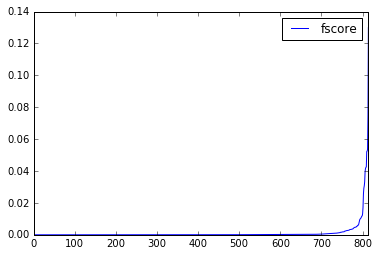

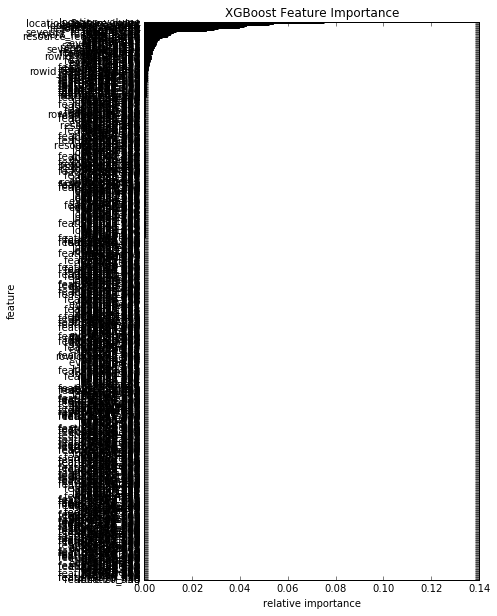

In [42]:
#xgboost features
#xgboost feature selection

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

def get_data():
    tr = x_train

    features = list(x_train.columns)

    ytrain = y_train

    xtrain = tr[features]

    return features, xtrain, ytrain


features, xtrain, ytrain = get_data()
ceate_feature_map(features)

xgb_params =  {'objective':'multi:softprob','eval_metric' : 'mlogloss', 'num_class':3,'eta': 0.01,
         'subsample':1.0, 'max_depth':6, 'colsample_bytree':0.3,'nthread':-1}

num_rounds = 2222222

dtrain = xgb.DMatrix(xtrain, label=ytrain)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')
df.to_csv("xgb features.csv")